In [1]:
# Packages to Install or Import

# pip install statsmodels
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


# Data Cleaning

In [2]:
# Download File and Clean Header Titles

measurements_df = pd.read_csv('measurements_2024-07-25.csv',index_col=0, dtype='string')
measurements_df.columns = measurements_df.columns.str.replace(r'Locations → ', '')
column_names = measurements_df.columns
print(column_names)

Index(['Style', 'Client ID', 'Upload', 'Download', 'Jitter', 'Latency',
       'Processed', 'Processed At', 'Created At', 'Updated At',
       'Extended Info', 'Location ID', 'Measured By ID', 'Client Version',
       'Client Distribution', 'Network Interfaces', 'Download Total Bytes',
       'Upload Total Bytes', 'Account ID', 'IP', 'Autonomous System ID',
       'Loss Rate', 'Lonlat', 'Wireless', 'Interface', 'Signal', 'Tx Speed',
       'Frequency', 'Channel', 'Width', 'Noise', 'Gzip', 'ID', 'Name',
       'Address', 'Latitude', 'Longitude', 'Created By ID', 'Created At',
       'Updated At', 'Expected Mbps Up', 'Expected Mbps Down',
       'Test Requested', 'State', 'County', 'State Fips', 'County Fips',
       'Manual Lat Long', 'Automatic Location', 'Account ID', 'Download Avg',
       'Upload Avg', 'Location Group ID', 'Deleted At', 'Lonlat',
       'Offline Since', 'Online', 'Notified When Online', 'Measurements Count',
       'Measurements Download Sum', 'Measurements Upload S

In [3]:
# Remove Location IDs that are not Appropriate Clinics or Anchor Institutions

def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

measurements_df = filter_rows_by_values(measurements_df, "Location ID", ['Kristina Andrews House', 'Dillingham - Bill', 'Dillingham - Brian', 'Dillingham - Johanna', 'Dillingham - Khouse'])
measurements_df.head(3)

,Style,Client ID,Upload,Download,Jitter,Latency,Processed,Processed At,Created At,Updated At,...,Upload Avg,Location Group ID,Deleted At,Lonlat,Offline Since,Online,Notified When Online,Measurements Count,Measurements Download Sum,Measurements Upload Sum
ID,,,,,,,,,,,,,,,,,,,,,
2117171,OOKLA,579,28.38,24.53,0.29,25.35,true,"September 29, 2023, 7:34 AM","September 29, 2023, 7:34 AM","September 29, 2023, 7:34 AM",...,27.35,<NA>,<NA>,0101000020E6100000AA7ABD84184164C08A55AE265BBD...,<NA>,true,true,"2,654","66,610.73","72,588.4"
2984784,OOKLA,579,28.51,23.28,0.2,25.23,true,"December 20, 2023, 6:43 AM","December 20, 2023, 6:43 AM","December 20, 2023, 6:43 AM",...,27.35,<NA>,<NA>,0101000020E6100000AA7ABD84184164C08A55AE265BBD...,<NA>,true,true,"2,654","66,610.73","72,588.4"
2987560,OOKLA,579,28.44,24.53,0.29,25.14,true,"December 20, 2023, 12:23 PM","December 20, 2023, 12:23 PM","December 20, 2023, 12:23 PM",...,27.35,<NA>,<NA>,0101000020E6100000AA7ABD84184164C08A55AE265BBD...,<NA>,true,true,"2,654","66,610.73","72,588.4"


In [4]:
# Define network measurements as numeric and dates as dates

measurements_df['Jitter'] = measurements_df['Jitter'].replace(',','', regex=True)
measurements_df['Latency'] = measurements_df['Latency'].replace(',','', regex=True)

cols = ['Download','Upload','Latency','Jitter', 'Expected Mbps Up','Expected Mbps Down']
measurements_df[cols] = measurements_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
cols = ['Processed At','Created At', 'Updated At']
measurements_df[cols] = measurements_df[cols].apply(pd.to_datetime, errors='coerce', axis=1)

measurements_df.groupby(['Location ID'])[['Download','Upload','Latency', 'Expected Mbps Up','Expected Mbps Down']].median().head()

,Download,Upload,Latency,Expected Mbps Up,Expected Mbps Down
Location ID,,,,,
Ambler Clinic,9.445,4.885,590.715,50.0,50.0
Atka Clinic,17.910,4.275,82.585,10.0,40.0
Deering Clinic,12.050,8.370,583.700,50.0,50.0
Deering Clinic- Starlink,107.780,9.400,80.250,10.0,100.0
Dillingham - BBAHC,185.030,24.725,32.220,300.0,300.0


In [5]:
# Adding Columns to Primary Data Frame
measurements_df.sort_values(by='Processed At')

# Creating new Columns
measurements_df['Year'] = measurements_df['Processed At'].dt.year
measurements_df['Month'] = measurements_df['Processed At'].dt.month
measurements_df['Week'] = measurements_df['Processed At'].dt.isocalendar().week
measurements_df['Day'] = measurements_df['Processed At'].dt.isocalendar().day
measurements_df['Date'] = pd.to_datetime(measurements_df[['Year','Month']].assign(day=1)).dt.to_period('M')
measurements_df['WDate'] = measurements_df['Processed At'].dt.strftime('%Y-%U')

# Adjust each date to the first day of the week (Monday) and normalize to strip the time
measurements_df['WDate'] = (
    (measurements_df['Processed At'] - pd.to_timedelta(measurements_df['Processed At'].dt.weekday, unit='D'))
    .dt.floor('D')  # This sets the time to midnight (00:00:00)
)

# Define the min and max dates for xlim
min_date = measurements_df['WDate'].min()
max_date = measurements_df['WDate'].max()

#measurements_df = measurements_df.loc[measurements_df['Date'] >= '2023-1-1']
measurements_df['Processed At'].agg(['min', 'max'])

min   2022-02-15 00:00:00
max   2024-07-25 04:45:00
Name: Processed At, dtype: datetime64[ns]

In [6]:
# Standardize Northwest Arctic
measurements_df['County'] = measurements_df['County'].replace({'Northwest Arctic Borough': 'Northwest Arctic'})
measurements_df['County'].value_counts()

Aleutians West Census Area    44925
Nome                          27901
Unorganized Borough           18692
Northwest Arctic               8340
North Slope                      62
Dillingham                       12
Name: County, dtype: Int64

In [7]:
# Add ISP Names to Dataframe

IPs = measurements_df['IP'].value_counts().rename_axis('unique_IPs').reset_index(name='counts')
IPs.to_csv('IPs.csv', encoding = 'utf-8')
IPs = pd.read_csv('IPs.csv',index_col=0)

ASNs = pd.read_csv('ASN_Lookup.csv',index_col=None)
ASNs = ASNs.set_axis(['IP', 'AS_No', 'AS_Name', 'AS_Range'], axis='columns')

measurements_df = pd.merge(measurements_df, ASNs, on = "IP", how = "inner")

In [8]:
# List of x-coordinates to draw vertical lines on
xcoords = ['2023-06-11', '2023-09-20', '2024-04-23']
xcoords = pd.to_datetime(xcoords)  # Convert xcoords to datetime objects

In [9]:
# Remove Ookla Outlier
#Outliers = measurements_df[measurements_df["Download"] > 800]
#Outliers['Processed At'].count()
#Outliers['Processed At'].agg(['min', 'max'])

#There are 50 measurements from NSRA between May 13th and May 25th where reported download speeds exceeded 500 Mbps. While none exceeded Gig speeds, all 50 reported speeds above 800 Mbps. All measurements were Ookla based and reported GCI as the ISP.
measurements_df = measurements_df[measurements_df.Download < 500]

In [10]:
# Helper function for consistent plotting
def plot_data(ax, df, title, lines=None):
    # Plot data and optionally store or use color from lines
    if lines is None:
        lines = [ax.plot(df.index, df[col], label=col)[0] for col in df.columns]
    else:
        for line, col in zip(lines, df.columns):
            ax.plot(df.index, df[col], label=col, color=line.get_color())

    # Standardize plot appearance
    ax.set(title=title, xlabel='Date', ylabel='Speed (MBPS)', ylim=(0, 300))
    ax.set_xlim(min_date, max_date)
    ax.set_xticks(pd.date_range(start=min_date, end=max_date, freq='M'))
    ax.tick_params(axis='x', rotation=30, labelsize=10)
    for xc in xcoords:
        ax.axvline(x=xc, color='black', linestyle='--')
    return lines

## Create subsets of the database

In [11]:
#Identify 'OOKLA', 'NDT7'
ookla = measurements_df[(measurements_df['Style'] == 'OOKLA')]
NDT7 = measurements_df[(measurements_df['Style'] == 'NDT7')]

measurements_df.groupby(['Style'])[['Download','Upload','Jitter','Latency','Expected Mbps Up','Expected Mbps Down']].median()
#NDT7['Processed At'].agg(['min', 'max'])

,Download,Upload,Jitter,Latency,Expected Mbps Up,Expected Mbps Down
Style,,,,,,
NDT7,26.17,5.47,NaN,72.73,30.0,30.0
OOKLA,28.21,27.03,0.63,29.26,30.0,30.0


# Scatter Plots

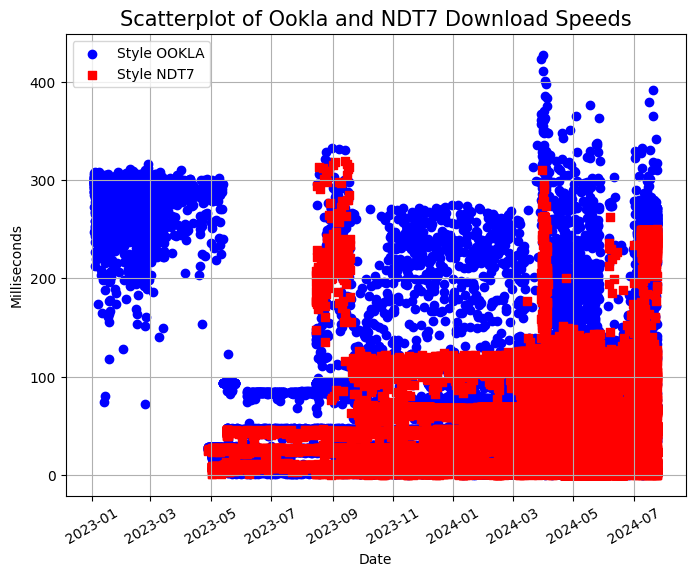

In [12]:
# Adjust category labels based on your actual data
categories = measurements_df['Style'].unique()

# Create scatterplot
plt.figure(figsize=(8, 6))

# Plot each category separately to differentiate them by color or marker
for category, marker, color in zip(categories, ['o', 's'], ['blue', 'red']):
    subset = measurements_df[measurements_df['Style'] == category]
    plt.scatter(subset['Processed At'], subset['Download'], label=f'Style {category}', marker=marker, color=color)

# 
# Add labels and legend
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.title('Scatterplot of Ookla and NDT7 Download Speeds', fontsize=15)
plt.xticks(rotation=30, fontsize=10)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

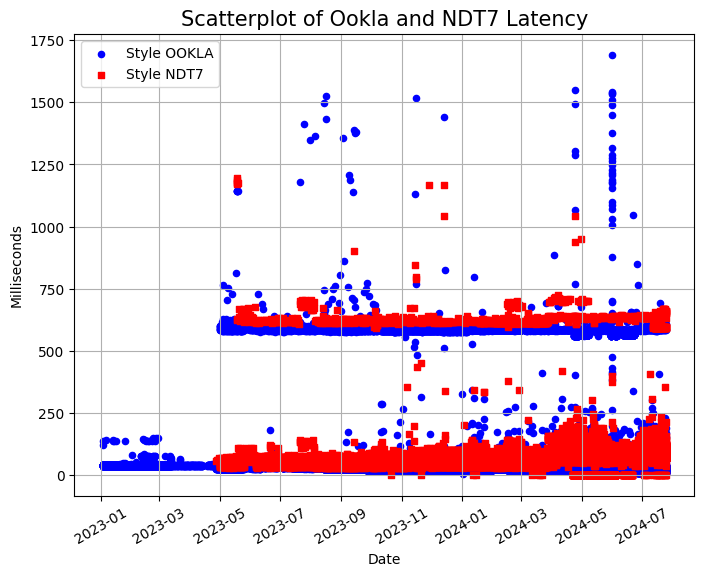

In [13]:
# Adjust category labels based on your actual data
categories = measurements_df['Style'].unique()

# Create scatterplot
plt.figure(figsize=(8, 6))

# Plot each category separately to differentiate them by color or marker
for category, marker, color in zip(categories, ['o', 's'], ['blue', 'red']):
    subset = measurements_df[measurements_df['Style'] == category]
    plt.scatter(subset['Processed At'], subset['Latency'], label=f'Style {category}', marker=marker, s= 20, color=color)

# 
# Add labels and legend
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.title('Scatterplot of Ookla and NDT7 Latency', fontsize=15)
plt.xticks(rotation=30, fontsize=10)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Ookla and NDT7 comparison

In [14]:
newookla = measurements_df[measurements_df['Processed At'] > '2023-04-27']
pd.crosstab(index=newookla['Location ID'], columns=newookla['Style']).head()

Style,NDT7,OOKLA
Location ID,,
Ambler Clinic,391,411
Atka Clinic,1290,130
Deering Clinic,401,414
Deering Clinic- Starlink,31,31
ELI Clinic,112,112


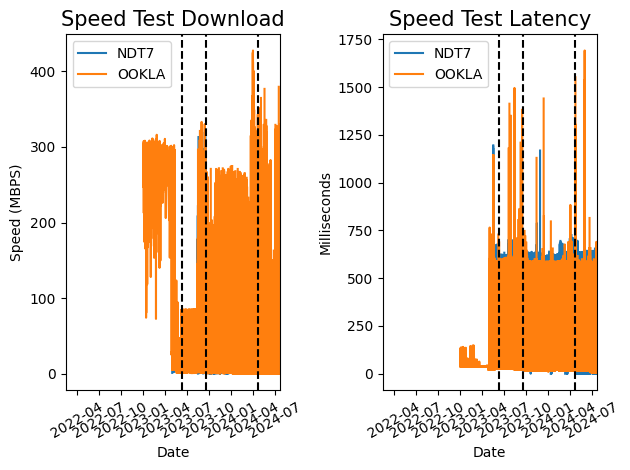

In [15]:

# Create download and latency plot for the Speed Test Styles
df_style_down = measurements_df.groupby(['Processed At', 'Style'])['Download'].median().unstack()
df_style_lat = measurements_df.groupby(['Processed At', 'Style'])['Latency'].median().unstack()

plt.subplot(1, 2, 1)

for col in ['NDT7', 'OOKLA']:
    plt.plot(df_style_down.index, df_style_down[col], label=col)

# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
   
# Adding a plot title and customizing its font size
plt.title('Speed Test Download', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('type_download.jpg')

plt.subplot(1, 2, 2)

for col in ['NDT7', 'OOKLA']:
    plt.plot(df_style_lat.index, df_style_lat[col], label=col)

# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
# Adding a plot title and customizing its font size
plt.title('Speed Test Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('type_latency.jpg')
plt.tight_layout()

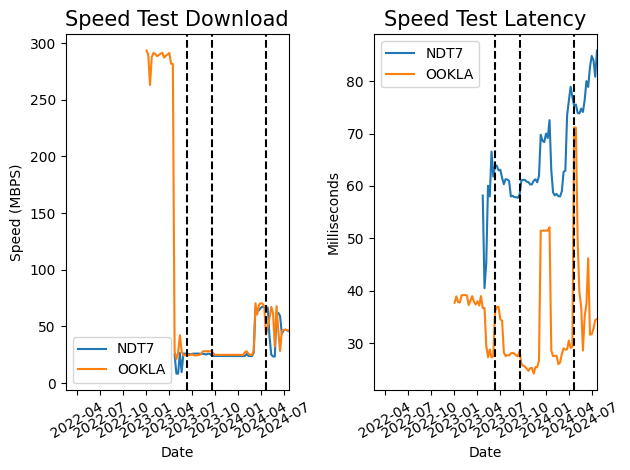

In [16]:

# Create download and latency plot for the Speed Test Styles
df_style_down = measurements_df.groupby(['WDate', 'Style',])['Download'].median().unstack()
df_style_lat = measurements_df.groupby(['WDate', 'Style',])['Latency'].median().unstack()

plt.subplot(1, 2, 1)

for col in ['NDT7', 'OOKLA']:
    plt.plot(df_style_down.index, df_style_down[col], label=col)

# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
   
# Adding a plot title and customizing its font size
plt.title('Speed Test Download', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('type_download.jpg')

plt.subplot(1, 2, 2)

for col in ['NDT7', 'OOKLA']:
    plt.plot(df_style_lat.index, df_style_lat[col], label=col)

# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
# Adding a plot title and customizing its font size
plt.title('Speed Test Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('type_latency.jpg')
plt.tight_layout()

# Exploratory Analysis

In [17]:
#measurements_df['AS_Name'].value_counts()
#measurements_df['Style'].value_counts()
measurements_df['County'].value_counts()

Aleutians West Census Area    44925
Nome                          19837
Unorganized Borough           18692
Northwest Arctic               8340
North Slope                      62
Name: County, dtype: Int64

In [18]:
#Pivot Table to Test Hypothesis
pd.set_option("display.max_columns", None)

ookla.pivot_table(
    values=["Download"], index="Expected Mbps Down",
    columns="Location ID", aggfunc=["mean"],
    ).head()

mean  \
                                           Download   
Location ID        Ambler Clinic                      
Expected Mbps Down                                    
5.0                                             NaN   
10.0                                            NaN   
25.0                                            NaN   
30.0                                            NaN   
40.0                                            NaN   

                                                     \
                                                      
Location ID        Atka Clinic                        
Expected Mbps Down                                    
5.0                                             NaN   
10.0                                            NaN   
25.0                                            NaN   
30.0                                            NaN   
40.0                                      19.372923   

                                                     \
                                                      
Location ID        Deering Clinic                     
Expected Mbps Down                                    
5.0                                             NaN   
10.0                                            NaN   
25.0                                            NaN   
30.0                                            NaN   
40.0                                            NaN   

                                                     \
                                                      
Location ID        Deering Clinic- Starlink           
Expected Mbps Down                                    
5.0                                             NaN   
10.0                                            NaN   
25.0                                            NaN   
30.0                                            NaN   
40.0                                            NaN   

                                                     \
                                                      
Location ID        ELI Clinic                         
Expected Mbps Down                                    
5.0                                             NaN   
10.0                                            NaN   
25.0                                            NaN   
30.0                                      25.729646   
40.0                                            NaN   

                                                     \
                                                      
Location ID        GAM Clinic                         
Expected Mbps Down                                    
5.0                                             NaN   
10.0                                            NaN   
25.0                                            NaN   
30.0                                        0.51902   
40.0                                            NaN   

                                                     \
                                                      
Location ID        GLV Clinic                         
Expected Mbps Down                                    
5.0                                             NaN   
10.0                                            NaN   
25.0                                            NaN   
30.0                                      24.321867   
40.0                                            NaN   

                                                     \
                                                      
Location ID        KKA Clinic                         
Expected Mbps Down                                    
5.0                                             NaN   
10.0                                            NaN   
25.0                                            NaN   
30.0                                      23.238636   
40.0                                            NaN   

                                                     \
                        

In [114]:
#Crosstabs to Test Hypothesis
pd.crosstab(index=ookla['Location ID'], columns=ookla['Date'])

Date,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07
Location ID,,,,,,,,,,,,,,,,,,,
Ambler Clinic,0,0,0,0,13,30,31,31,30,31,30,31,31,29,30,27,24,24,19
Atka Clinic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,24,31,0
Deering Clinic,0,0,0,0,17,30,30,29,30,31,29,32,31,29,29,27,25,24,21
Deering Clinic- Starlink,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,21
ELI Clinic,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,27,31,30,24
GAM Clinic,0,0,0,0,0,0,0,0,0,0,0,0,56,115,113,45,31,30,24
GLV Clinic,0,0,0,0,5,120,118,124,119,121,120,124,124,116,113,45,31,30,24
KKA Clinic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,31,30,23
KTS Clinic,0,0,0,0,101,0,0,73,117,121,113,124,120,115,114,45,31,30,1


In [20]:
#More exploratory analysis

pd.crosstab(index=measurements_df['Location ID'], columns=measurements_df['Expected Mbps Down'])
#measurements_df['Style'].value_counts()


Expected Mbps Down,5.0,10.0,25.0,30.0,40.0,41.1,50.0,75.0,100.0,120.0,150.0,300.0
Location ID,,,,,,,,,,,,
Ambler Clinic,0,0,0,0,0,0,802,0,0,0,0,0
Atka Clinic,0,0,0,0,1420,0,0,0,0,0,0,0
Deering Clinic,0,0,0,0,0,0,815,0,0,0,0,0
Deering Clinic- Starlink,0,0,0,0,0,0,0,0,62,0,0,0
ELI Clinic,0,0,0,225,0,0,0,0,0,0,0,0
GAM Clinic,0,0,0,829,0,0,0,0,0,0,0,0
GLV Clinic,0,0,0,2667,0,0,0,0,0,0,0,0
KKA Clinic,0,0,0,222,0,0,0,0,0,0,0,0
KTS Clinic,0,0,0,2236,0,0,0,0,0,0,0,0


In [21]:
ookla.groupby(['Location ID'])[['Download','Upload','Jitter','Latency','Expected Mbps Up','Expected Mbps Down']].median().head()

,Download,Upload,Jitter,Latency,Expected Mbps Up,Expected Mbps Down
Location ID,,,,,,
Ambler Clinic,10.13,7.910,0.5600,584.44,50.0,50.0
Atka Clinic,20.32,9.285,0.9085,560.31,10.0,40.0
Deering Clinic,15.24,8.880,0.5350,583.72,50.0,50.0
Deering Clinic- Starlink,150.25,16.070,7.4000,88.50,10.0,100.0
ELI Clinic,24.10,5.140,0.3800,27.84,30.0,30.0


In [22]:
ookla.groupby(['AS_Name'])[['Download','Upload','Jitter','Latency','Expected Mbps Up','Expected Mbps Down']].median()

,Download,Upload,Jitter,Latency,Expected Mbps Up,Expected Mbps Down
AS_Name,,,,,,
ALSK-7782,103.320,8.280,5.655,99.185,30.00,30.0
COGENT-174,130.510,129.270,1.180,71.720,150.00,150.0
GCI,24.940,9.090,0.530,27.520,30.00,30.0
SPACEX-STARLINK,191.930,20.580,4.060,71.430,30.00,30.0
VIASAT-SP-BACKBONE,6.395,2.785,37.115,710.345,3.87,41.1


# Speed Tier Lists

In [23]:
pd.crosstab(index=measurements_df['Expected Mbps Down'], columns=measurements_df['County'])

County,Aleutians West Census Area,Nome,North Slope,Northwest Arctic,Unorganized Borough
Expected Mbps Down,,,,,
5.0,13984,0,0,0,0
10.0,0,2126,0,0,0
25.0,11542,0,0,0,0
30.0,3965,8613,0,0,4071
40.0,1415,0,0,0,1420
41.1,0,0,0,219,0
50.0,0,0,0,3354,0
75.0,14019,0,0,0,0
100.0,0,0,0,169,0


In [24]:
# Create download plot for the Speed Test Styles
df_tier_down = NDT7.groupby(['WDate', 'Expected Mbps Down',])[['Download']].median().reset_index()
df_tier_down = df_tier_down.pivot(index='WDate', columns='Expected Mbps Down', values='Download')
df_tier_down.head()

Expected Mbps Down,5.0,10.0,25.0,30.0,40.0,41.1,50.0,75.0,100.0,120.0,150.0,300.0
WDate,,,,,,,,,,,,
2023-04-24,NaN,NaN,NaN,25.365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01,NaN,5.42,NaN,24.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-08,NaN,5.43,NaN,25.615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-15,NaN,4.37,NaN,25.660,NaN,NaN,43.580,NaN,NaN,NaN,NaN,NaN
2023-05-22,NaN,4.02,NaN,16.730,NaN,NaN,43.105,NaN,NaN,NaN,NaN,NaN


In [25]:
df_tier_down = NDT7.groupby(['WDate', 'Expected Mbps Down',])[['Download']].median().unstack()
df_tier_down.head()

Download                                                \
Expected Mbps Down    5.0   10.0  25.0    30.0  40.0  41.1    50.0  75.0    
WDate                                                                       
2023-04-24              NaN   NaN   NaN  25.365   NaN   NaN     NaN   NaN   
2023-05-01              NaN  5.42   NaN  24.400   NaN   NaN     NaN   NaN   
2023-05-08              NaN  5.43   NaN  25.615   NaN   NaN     NaN   NaN   
2023-05-15              NaN  4.37   NaN  25.660   NaN   NaN  43.580   NaN   
2023-05-22              NaN  4.02   NaN  16.730   NaN   NaN  43.105   NaN   

                                            
Expected Mbps Down 100.0 120.0 150.0 300.0  
WDate                                       
2023-04-24           NaN   NaN   NaN   NaN  
2023-05-01           NaN   NaN   NaN   NaN  
2023-05-08           NaN   NaN   NaN   NaN  
2023-05-15           NaN   NaN   NaN   NaN  
2023-05-22           NaN   NaN   NaN   NaN

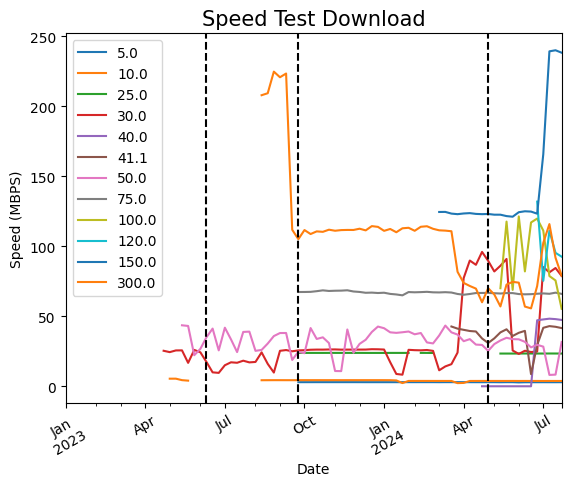

In [26]:
# Group Like Location IDs
tiers = ['5.0','10.0','25.0','30.0','40.0','41.1','50.0','75.0','100.0','120.0','150.0']

# Create download plot for the Speed Test Styles
df_tier_down = NDT7.groupby(['WDate', 'Expected Mbps Down',])['Download'].median().unstack()

# Create download plot for the Speed Test Styles
#df_tier_down = NDT7.groupby(['WDate', 'Expected Mbps Down',])[['Download']].median().reset_index()
#df_tier_down = df_tier_down.pivot(index='WDate', columns='Expected Mbps Down', values='Download')

# Define the min and max dates for xlim
min_date = measurements_df['WDate'].min()
max_date = measurements_df['WDate'].max()

df_tier_down.plot(kind='line')

# Adding a plot title and customizing its font size
plt.title('Speed Test Download', fontsize=15)


# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')


# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('tier_download.jpg')


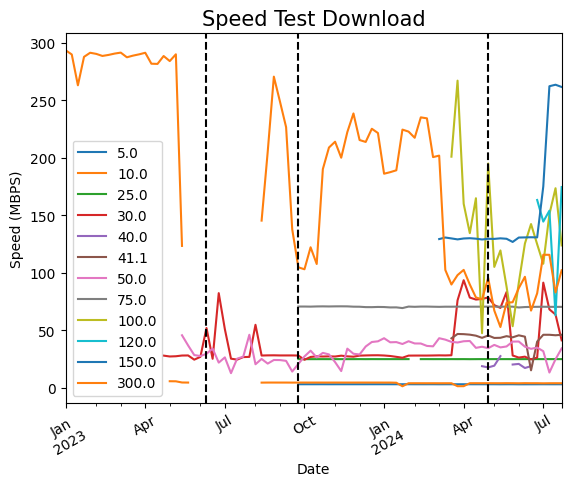

In [27]:
# Group Like Location IDs
tiers = ['5.0','10.0','25.0','30.0','40.0','41.1','50.0','75.0','100.0','120.0','150.0']

# Create download plot for the Speed Test Styles
df_tier_down = ookla.groupby(['WDate', 'Expected Mbps Down',])['Download'].median().unstack()

df_tier_down.plot(kind='line')

# Add vertical lines to the second subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Adding a plot title and customizing its font size
plt.title('Speed Test Download', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range


plt.savefig('tier_download.jpg')


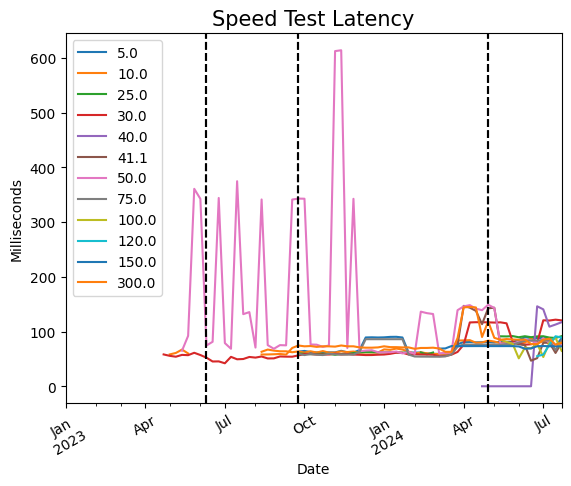

In [28]:
# Create download plot for the Speed Test Styles
df_tier_lat = NDT7.groupby(['WDate', 'Expected Mbps Down',])['Latency'].median().unstack()

df_tier_lat.plot(kind='line')

# Add vertical lines to the second subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Adding a plot title and customizing its font size
plt.title('Speed Test Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.legend()

for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('tier_latency.jpg')


# Clinic Timeseries 

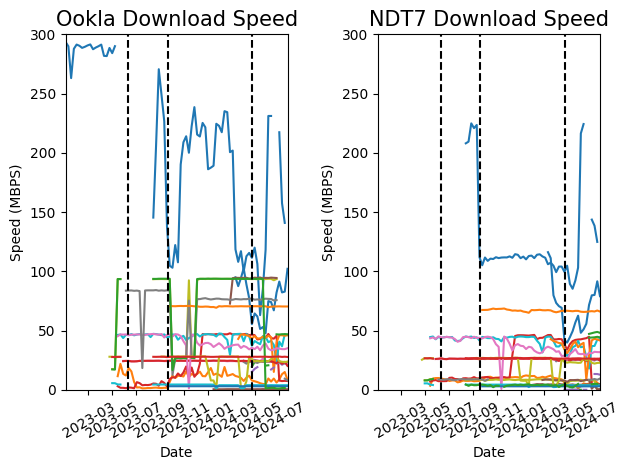

In [29]:
# Charts for Location Downloads
clinics = ['NSRH','Ambler Clinic','Atka Clinic','Deering Clinic', 'ELI Clinic','GAM Clinic','GLV Clinic','KKA Clinic','KTS Clinic', 'Kiana Clinic', 'Maniilaq IT -OTZ','Noatak Clinic','Noorvik Clinic', 'SMK Clinic', 'STG Clinic', 'SVA Clinic', 'Selawik Clinic','TLA Clinic','UNK Clinic','UNK Office','Unalaska BH Clinic','Unalaska Clinic','WAA Clinic','WBB Clinic']

# Create Download Speed plots for the Styles
ookla_loc = ookla.groupby(['WDate', 'Location ID'])['Download'].median().unstack()
NDT7_loc = NDT7.groupby(['WDate', 'Location ID',])['Download'].median().unstack()

plt.subplot(1, 2, 1)

for col in clinics:
    plt.plot(ookla_loc.index, ookla_loc[col], label=col) #color="0.5"

# Add vertical lines to the second subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Adding a plot title and customizing its font size
plt.title('Ookla Download Speed', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.ylim(0, 300)
#plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('loc_ookla_download.jpg')

plt.subplot(1, 2, 2)

for col in clinics:
    plt.plot(NDT7_loc.index, NDT7_loc[col], label=col) #color="0.5"

# Add vertical lines to the second subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
# Adding a plot title and customizing its font size
plt.title('NDT7 Download Speed', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.ylim(0, 300)
#plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('loc_download.jpg')

plt.tight_layout()


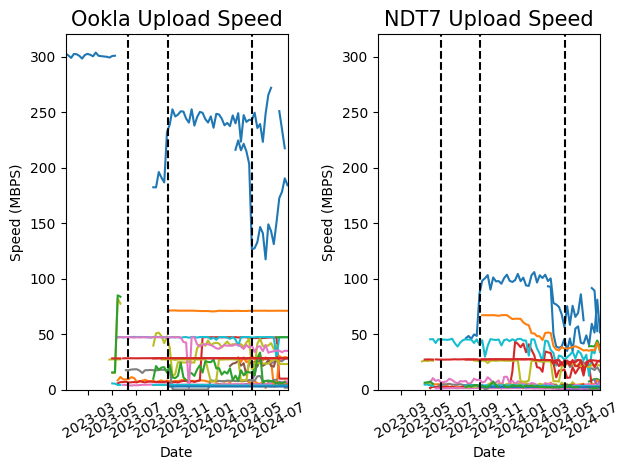

In [30]:
# Charts for Location Downloads
clinics = ['NSRH','Ambler Clinic','Atka Clinic','Deering Clinic', 'ELI Clinic','GAM Clinic','GLV Clinic','KKA Clinic','KTS Clinic', 'Kiana Clinic', 'Maniilaq IT -OTZ','Noatak Clinic','Noorvik Clinic', 'SMK Clinic', 'STG Clinic', 'SVA Clinic', 'Selawik Clinic','TLA Clinic','UNK Clinic','UNK Office','Unalaska BH Clinic','Unalaska Clinic','WAA Clinic','WBB Clinic']

#create time series plot
ookla_loc = ookla.groupby(['WDate', 'Location ID'])[['Upload']].median().reset_index()
ookla_loc = ookla_loc.pivot(index='WDate', columns='Location ID', values='Upload')

# Create latency plot for the Speed Test Styles
NDT7_loc = NDT7.groupby(['WDate', 'Location ID',])[['Upload']].median().reset_index()
NDT7_loc = NDT7_loc.pivot(index='WDate', columns='Location ID', values='Upload')

plt.subplot(1, 2, 1)

for col in clinics:
    plt.plot(ookla_loc.index, ookla_loc[col], label=col) # for BW add color="0.5"

# Add vertical lines to the second subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Adding a plot title and customizing its font size
plt.title('Ookla Upload Speed', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.ylim(0, 320)
#plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('loc_ookla_upload.jpg')

plt.subplot(1, 2, 2)

for col in clinics:
    plt.plot(NDT7_loc.index, NDT7_loc[col], label=col) # for BW add color="0.5"

# Add vertical lines to the second subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
# Adding a plot title and customizing its font size
plt.title('NDT7 Upload Speed', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.ylim(0, 320)
#plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('loc_upload.jpg')

plt.tight_layout()


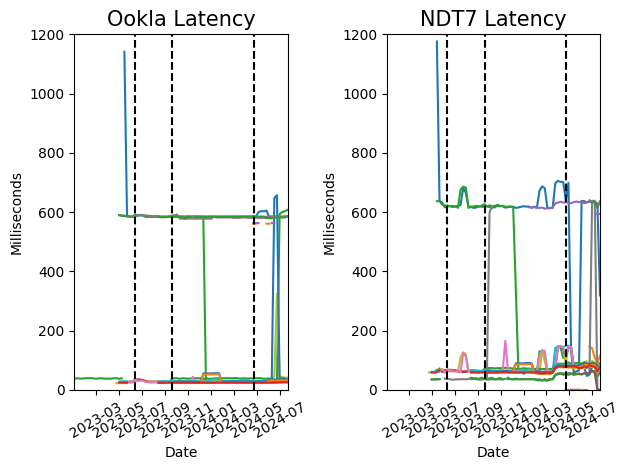

In [31]:
# Charts for Location Downloads
clinics = ['Ambler Clinic','Atka Clinic','Deering Clinic', 'ELI Clinic','GAM Clinic','GLV Clinic','KKA Clinic','KTS Clinic', 'Kiana Clinic', 'Maniilaq IT -OTZ','Noatak Clinic','Noorvik Clinic', 'NSRH', 'SMK Clinic', 'STG Clinic', 'SVA Clinic', 'Selawik Clinic','TLA Clinic','UNK Clinic','UNK Office','Unalaska BH Clinic','Unalaska Clinic','WAA Clinic','WBB Clinic']

#create time series latency plots for Style
ookla_loc = ookla.groupby(['WDate', 'Location ID'])['Latency'].median().unstack()
NDT7_loc = NDT7.groupby(['WDate', 'Location ID',])['Latency'].median().unstack()

plt.subplot(1, 2, 1)

for col in clinics:
    plt.plot(ookla_loc.index, ookla_loc[col], label=col) # for BW add color="0.5"

# Add vertical lines to the second subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Adding a plot title and customizing its font size
plt.title('Ookla Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.ylim(0, 1200)

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('loc_ookla_latency.jpg')

plt.subplot(1, 2, 2)

for col in clinics:
    plt.plot(NDT7_loc.index, NDT7_loc[col], label=col) # for BW add color="0.5"

# Add vertical lines to the second subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
# Adding a plot title and customizing its font size
plt.title('NDT7 Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.ylim(0, 1200)

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('loc_latency.jpg')

plt.tight_layout()


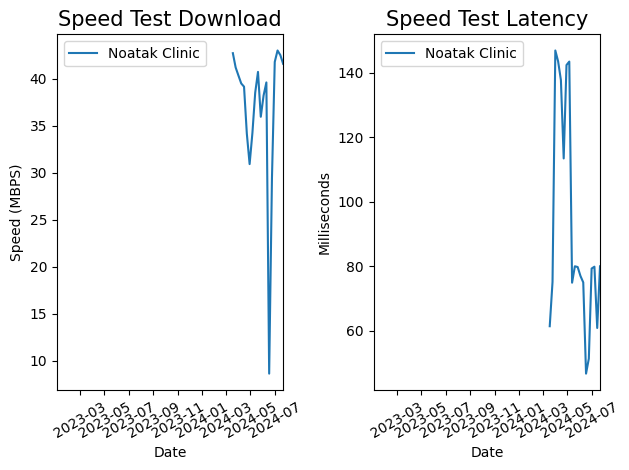

In [32]:
# Charts for Experimentation

test = ['Noatak Clinic']
clinics = ['NSRH','Ambler Clinic','Atka Clinic','Deering Clinic', 'ELI Clinic','GAM Clinic','GLV Clinic','KKA Clinic','KTS Clinic', 'Kiana Clinic', 'Maniilaq IT -OTZ','Noatak Clinic','Noorvik Clinic', 'SMK Clinic', 'STG Clinic', 'SVA Clinic', 'Selawik Clinic','TLA Clinic','UNK Clinic','UNK Office','Unalaska BH Clinic','Unalaska Clinic','WAA Clinic','WBB Clinic']
starlink = ['Deering Clinic- Starlink','Kiana Clinic-Starlink','Point Hope Clinic Starlink']
saintpaul = ['St. Paul community Health Center']
other = ['Kotzebue Broadcasting Studio', 'Nome Elementary School','Nome-Beltz Middle High School','Unalaska Head Start']

#create time series plot
df_clinics = NDT7.groupby(['WDate', 'Location ID'])['Download'].median().unstack()
df_clinics_lat = NDT7.groupby(['WDate', 'Location ID',])['Latency'].median().unstack()

plt.subplot(1, 2, 1)

for col in test:
    plt.plot(df_clinics.index, df_clinics[col], label=col)  # for BW add color="0.5"

# Adding a plot title and customizing its font size
plt.title('Speed Test Download', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('place_download.jpg')

plt.subplot(1, 2, 2)

for col in test:
    plt.plot(df_clinics_lat.index, df_clinics_lat[col], label=col)  # for BW add color="0.5"
    
# Adding a plot title and customizing its font size
plt.title('Speed Test Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('place_latency.jpg')

plt.tight_layout()


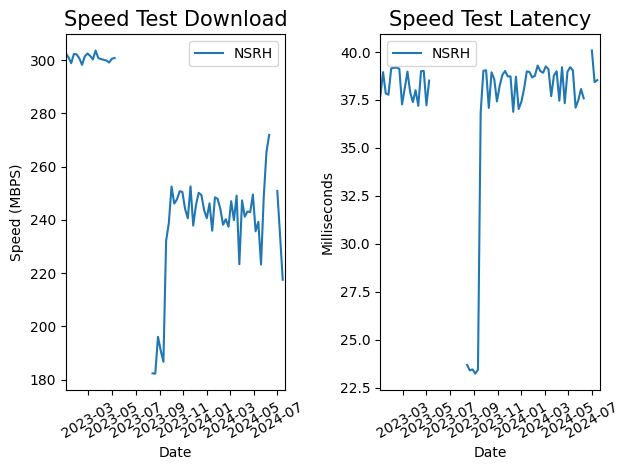

In [33]:
# Charts for Experimentation

test = ['NSRH']
clinics = ['NSRH','Ambler Clinic','Atka Clinic','Deering Clinic', 'ELI Clinic','GAM Clinic','GLV Clinic','KKA Clinic','KTS Clinic', 'Kiana Clinic', 'Maniilaq IT -OTZ','Noatak Clinic','Noorvik Clinic', 'SMK Clinic', 'STG Clinic', 'SVA Clinic', 'Selawik Clinic','TLA Clinic','UNK Clinic','UNK Office','Unalaska BH Clinic','Unalaska Clinic','WAA Clinic','WBB Clinic']
starlink = ['Deering Clinic- Starlink','Kiana Clinic-Starlink','Point Hope Clinic Starlink']
saintpaul = ['St. Paul community Health Center']
other = ['Kotzebue Broadcasting Studio', 'Nome Elementary School','Nome-Beltz Middle High School','Unalaska Head Start']

#create time series plot
df_clinics = ookla.groupby(['WDate', 'Location ID'])[['Upload']].median().reset_index()
df_clinics = df_clinics.pivot(index='WDate', columns='Location ID', values='Upload')

# Create latency plot for the Speed Test Styles
df_clinics_lat = ookla.groupby(['WDate', 'Location ID',])[['Latency']].median().reset_index()
df_clinics_lat = df_clinics_lat.pivot(index='WDate', columns='Location ID', values='Latency')

plt.subplot(1, 2, 1)

for col in test:
    plt.plot(df_clinics.index, df_clinics[col], label=col)  # for BW add color="0.5"

# Adding a plot title and customizing its font size
plt.title('Speed Test Download', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('place_download.jpg')

plt.subplot(1, 2, 2)

for col in test:
    plt.plot(df_clinics_lat.index, df_clinics_lat[col], label=col)  # for BW add color="0.5"
    
# Adding a plot title and customizing its font size
plt.title('Speed Test Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('place_latency.jpg')

plt.tight_layout()


# ISP Timeseries

In [34]:
newookla = measurements_df[measurements_df['Processed At'] > '2023-04-27']
pd.crosstab(index=newookla['Location ID'], columns=newookla['AS_Name']).head()

AS_Name,ALSK-7782,COGENT-174,GCI,SPACEX-STARLINK,VIASAT-SP-BACKBONE
Location ID,,,,,
Ambler Clinic,0,0,802,0,0
Atka Clinic,1263,0,157,0,0
Deering Clinic,0,0,815,0,0
Deering Clinic- Starlink,0,0,0,62,0
ELI Clinic,0,0,224,0,0


In [35]:
# Create download plot for the Speed Test Styles
df_tier_down = measurements_df.groupby(['WDate', 'Location ID',])[['Download']].median().reset_index()
df_tier_down = df_tier_down.pivot(index='WDate', columns='Location ID', values='Download')
df_tier_down

Location ID,Ambler Clinic,Atka Clinic,Deering Clinic,Deering Clinic- Starlink,ELI Clinic,GAM Clinic,GLV Clinic,KKA Clinic,KTS Clinic,Kiana Clinic,Kiana Clinic-Starlink,Kotzebue Broadcasting Studio,Maniilaq IT -OTZ,NSRH,Noatak Clinic,Nome Elementary School,Nome-Beltz Middle High School,Noorvik Clinic,Point Hope Clinic Starlink,SMK Clinic,STG Clinic,SVA Clinic,Selawik Clinic,St. Paul community Health Center,TLA Clinic,UNK Clinic,UNK Office,Unalaska BH Clinic,Unalaska Clinic,Unalaska Head Start,WAA Clinic,WBB Clinic
WDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293.520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289.850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287.795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,291.360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,5.290,47.165,45.415,135.595,24.835,2.530000,24.50,25.60,50.500000,19.410,70.985,23.505,73.545,NaN,34.650,125.050,125.040,44.845,144.265,23.455,NaN,9.490000,32.860,NaN,75.67,26.315,3.825,2.920,67.610,23.540,1.110,26.615
2024-07-01,8.375,47.765,7.020,109.525,25.055,1.400000,24.74,25.61,8.260000,39.465,NaN,23.635,84.240,156.300,43.340,166.375,166.405,44.470,81.235,25.500,NaN,0.906685,32.310,102.035,8.51,22.915,3.775,2.920,67.745,23.555,1.655,26.450
2024-07-08,9.270,48.390,5.685,103.805,23.805,2.045270,24.70,24.60,7.980000,37.015,NaN,23.630,80.060,142.965,43.735,248.580,248.180,45.120,116.040,24.215,13.33,3.270000,32.190,94.480,9.10,22.750,3.805,2.910,67.545,23.540,2.785,26.405


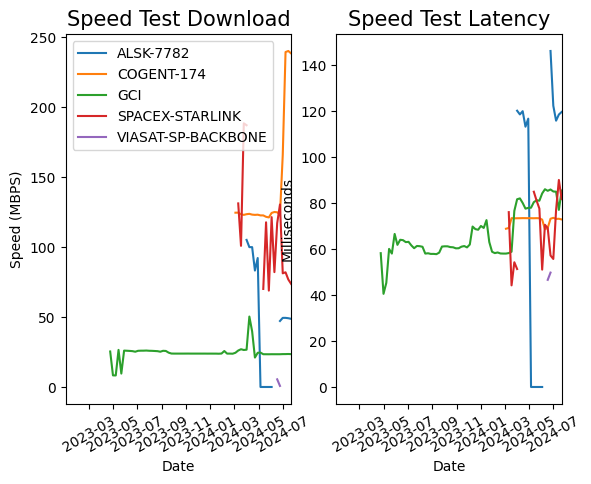

In [36]:
# Group Like Location IDs
ISPs = ['ALSK-7782','COGENT-174','GCI','SPACEX-STARLINK','VIASAT-SP-BACKBONE']

#create time series plot
df_isps = NDT7.groupby(['WDate', 'AS_Name'])['Download'].median().unstack()
df_isps_lat = NDT7.groupby(['WDate', 'AS_Name',])['Latency'].median().unstack()

plt.subplot(1, 2, 1)

for col in ISPs:
    plt.plot(df_isps.index, df_isps[col], label=col)

# Adding a plot title and customizing its font size
plt.title('Speed Test Download', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

#plt.savefig('place_download.jpg')

plt.subplot(1, 2, 2)

for col in ISPs:
    plt.plot(df_isps_lat.index, df_isps_lat[col], label=col)
    
# Adding a plot title and customizing its font size
plt.title('Speed Test Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('place_latency.jpg')
plt.show()



# Comparing Regions

In [37]:
# Group Like Location IDs
Regions = ['Aleutians West Census Area','Nome','Unorganized Borough','Northwest Arctic','North Slope']
measurements_df['County'].value_counts()


Aleutians West Census Area    44925
Nome                          19837
Unorganized Borough           18692
Northwest Arctic               8340
North Slope                      62
Name: County, dtype: Int64

In [38]:
pd.crosstab(index=measurements_df['Location ID'], columns=measurements_df['AS_Name']).head()

AS_Name,ALSK-7782,COGENT-174,GCI,SPACEX-STARLINK,VIASAT-SP-BACKBONE
Location ID,,,,,
Ambler Clinic,0,0,802,0,0
Atka Clinic,1263,0,157,0,0
Deering Clinic,0,0,815,0,0
Deering Clinic- Starlink,0,0,0,62,0
ELI Clinic,0,0,225,0,0


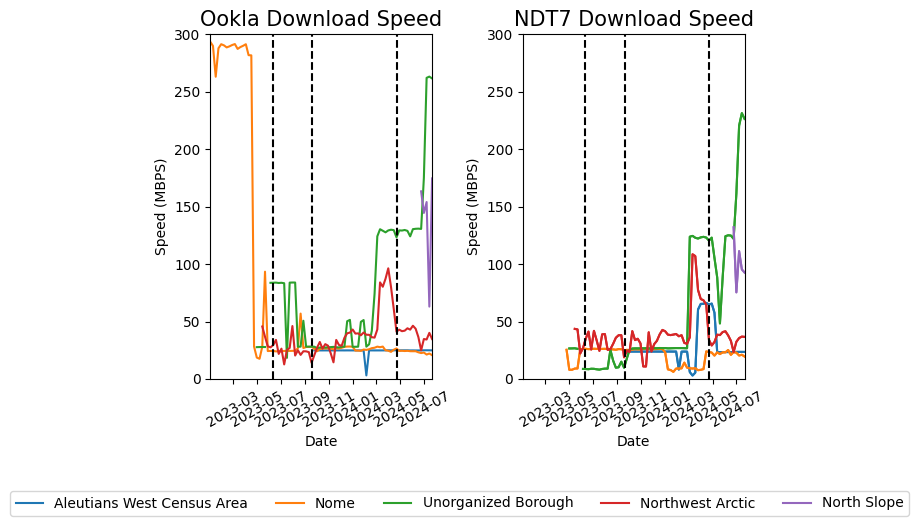

In [39]:
# Regional Time Series Plot
df_regions = ookla.groupby(['WDate', 'County'])['Download'].median().unstack()
df_regions_ndt7 = NDT7.groupby(['WDate', 'County',])['Download'].median().unstack()

plt.subplot(1, 2, 1)
lines = []  # To collect line handles for legend
for col in Regions:
    line, = plt.plot(df_regions.index, df_regions[col], label=col)  # Correctly unpacking the line
    lines.append(line)  # Append each line to the list

# Add vertical lines to the second subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Adding a plot title and customizing its font size
plt.title('Ookla Download Speed', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.ylim(0, 300)

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('region_ookla_download.jpg')

plt.subplot(1, 2, 2)

for i, col in enumerate(Regions):
    plt.plot(df_regions_ndt7.index, df_regions_ndt7[col], label=col, color=lines[i].get_color())  # Matching colors
    line, = plt.plot(df_regions_ndt7.index, df_regions_ndt7[col], label=col)

# Add vertical lines to the second subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
# Adding a plot title and customizing its font size
plt.title('NDT7 Download Speed', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.ylim(0, 300)

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

# Create a combined legend underneath the subplots
plt.figlegend(handles=lines, labels=[line.get_label() for line in lines], loc='lower center', ncol=len(Regions), bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom to make space for the legend
plt.savefig('region_ndt7_download.jpg')
plt.show()


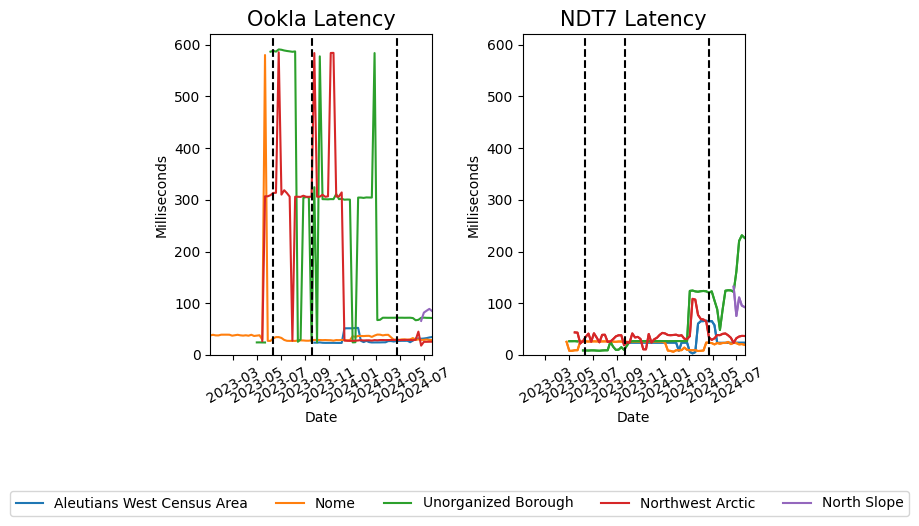

In [40]:
#create time series plot
df_regions = ookla.groupby(['WDate', 'County'])['Latency'].median().unstack()
df_regions_lat = NDT7.groupby(['WDate', 'County',])['Latency'].median().unstack()

plt.subplot(1, 2, 1)
lines = []  # To collect line handles for legend
for col in Regions:
    line, = plt.plot(df_regions.index, df_regions[col], label=col)  # Correctly unpacking the line
    lines.append(line)  # Append each line to the list

# Add vertical lines to the second subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Adding a plot title and customizing its font size
plt.title('Ookla Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.ylim(0, 620)

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

plt.savefig('region_ookla_download.jpg')

plt.subplot(1, 2, 2)

for i, col in enumerate(Regions):
    plt.plot(df_regions_ndt7.index, df_regions_ndt7[col], label=col, color=lines[i].get_color())  # Matching colors
    line, = plt.plot(df_regions_ndt7.index, df_regions_ndt7[col], label=col)

# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
# Adding a plot title and customizing its font size
plt.title('NDT7 Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.ylim(0, 620)

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)
plt.xlim(min_date, max_date)  # Set the x-axis limits to the desired date range

# Create a combined legend underneath the subplots
plt.figlegend(handles=lines, labels=[line.get_label() for line in lines], loc='lower center', ncol=len(Regions), bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust bottom to make space for the legend
plt.savefig('region_ndt7_download.jpg')
plt.show()


# Seperate sample to identify why latency has a bimodal distribution

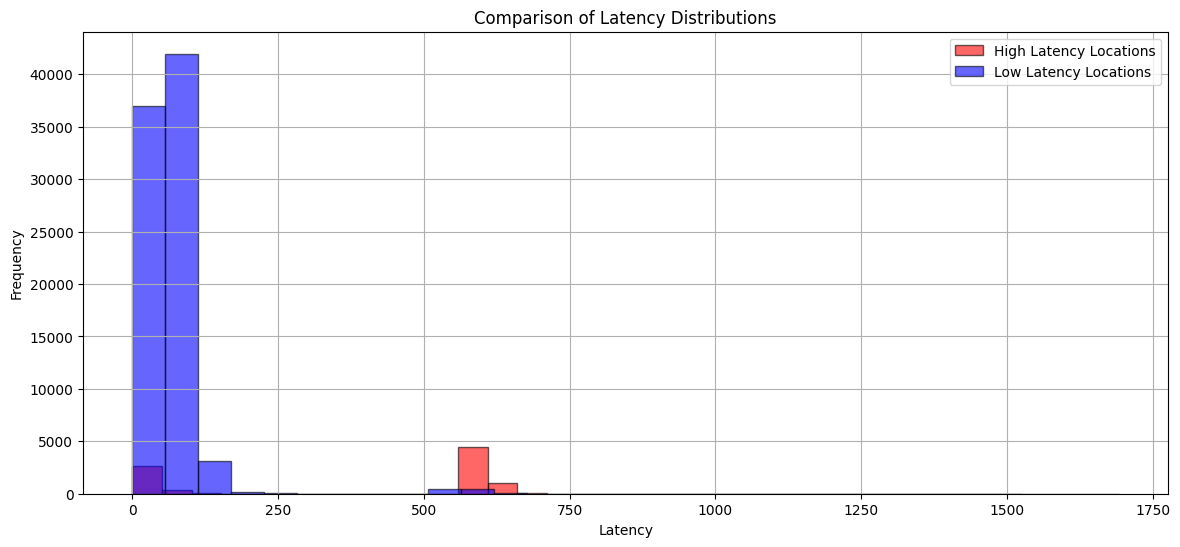

In [41]:
# Calculate the overall median latency
overall_median_latency = measurements_df['Latency'].median()

# Calculate the median latency for each location
location_median_latency = measurements_df.groupby('Location ID')['Latency'].median().reset_index()
location_median_latency.rename(columns={'Latency': 'Median Latency'}, inplace=True)

# Identify high and low latency locations
high_latency_locations = location_median_latency[location_median_latency['Median Latency'] > 500]
low_latency_locations = location_median_latency[location_median_latency['Median Latency'] <= 500]

# Get unique Location IDs for high and low latency groups
unique_high_latency_locations = high_latency_locations['Location ID'].unique()
unique_low_latency_locations = low_latency_locations['Location ID'].unique()

# Filter the original dataframe for high and low latency locations
high_latency_data = measurements_df[measurements_df['Location ID'].isin(unique_high_latency_locations)]
low_latency_data = measurements_df[measurements_df['Location ID'].isin(unique_low_latency_locations)]

# Plotting histograms to compare distributions
plt.figure(figsize=(14, 6))

# Histogram for high latency locations
plt.hist(high_latency_data['Latency'], bins=30, alpha=0.6, color='red', edgecolor='black', label='High Latency Locations')

# Histogram for low latency locations
plt.hist(low_latency_data['Latency'], bins=30, alpha=0.6, color='blue', edgecolor='black', label='Low Latency Locations')

plt.xlabel('Latency')
plt.ylabel('Frequency')
plt.title('Comparison of Latency Distributions')
plt.legend()
plt.grid(True)

In [42]:
high_latency_locations


,Location ID,Median Latency
0,Ambler Clinic,590.715
2,Deering Clinic,583.700
5,GAM Clinic,610.030
8,KTS Clinic,576.710
24,TLA Clinic,580.870
30,WAA Clinic,577.540


# Quintillion Cable Cut Example

In [43]:
df_monthly = NDT7.groupby(['Date', 'Location ID',])[['Download','Latency']].median().unstack().fillna('NA')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_monthly.head(30))



Download                                   \
Location ID Ambler Clinic                    Atka Clinic                        
Date                                                                            
2023-04                                   NA                               NA   
2023-05                                 9.44                               NA   
2023-06                                 9.55                               NA   
2023-07                                 7.41                               NA   
2023-08                                  7.5                               NA   
2023-09                                7.485                               NA   
2023-10                               10.745                               NA   
2023-11                                10.02                               NA   
2023-12                                10.67                               NA   
2024-01                                11.21                               NA   
2024-02                                10.54                               NA   
2024-03                                11.11                               NA   
2024-04                                 8.72                              0.0   
2024-05                                2.455                              0.0   
2024-06                                5.065                              0.0   
2024-07                                  6.9                             48.2   

                                                                               \
Location ID Deering Clinic                   Deering Clinic- Starlink           
Date                                                                            
2023-04                                   NA                               NA   
2023-05                                7.565                               NA   
2023-06                                 7.62                               NA   
2023-07                                 9.64                               NA   
2023-08                                 9.48                               NA   
2023-09                                10.21                               NA   
2023-10                                10.31                               NA   
2023-11                                10.24                               NA   
2023-12                               44.805                               NA   
2024-01                                45.86                               NA   
2024-02                                44.37                               NA   
2024-03                                45.28                               NA   
2024-04                                41.98                               NA   
2024-05                                40.49                               NA   
2024-06                                43.24                          125.545   
2024-07                                 4.61                            75.53   

                                                                               \
Location ID ELI Clinic                       GAM Clinic                         
Date                                                                            
2023-04                                   NA                               NA   
2023-05                                   NA                               NA   
2023-06                                   NA                               NA   
2023-07                                   NA                               NA   
2023-08                                   NA                               NA   
2023-09                                   NA                               NA   
2023-10                                   NA                               NA   
2023-11                                   NA                               NA   
2023-12                                   NA                     

In [44]:
#Effected
#- Ambler Clinic

#Unaffected
#Kiana Clinic
#GLV Clinic
#Selawick

#Went Out
#- NSRA
#- KTS Clinic
#- UNK Clinic
#- UNK Office
#- WAA Clinic
#- WBB Clinic

#Affected by the second fiber cut

#- Ambler
#- UNK Clinic
#- Kiana (Latency)
#- Maniilaq IT -OTZ (Latency)

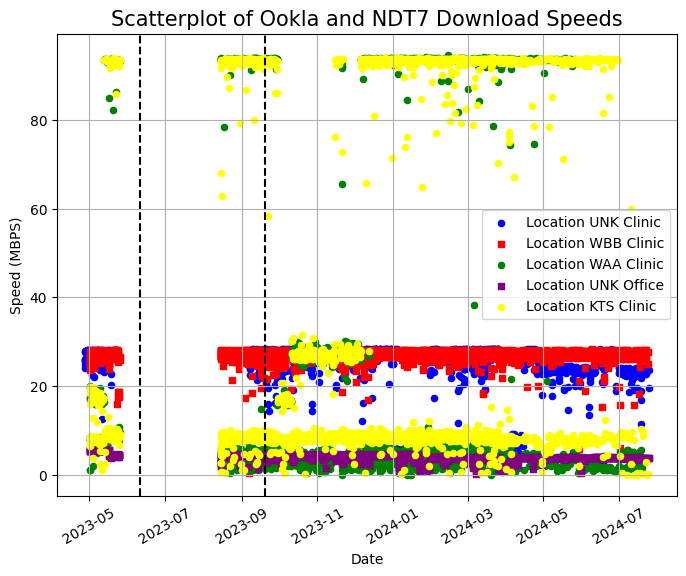

In [45]:
# Group Like Location IDs
breach1 = measurements_df[measurements_df['Location ID'].isin(['KTS Clinic','UNK Clinic','UNK Office','WAA Clinic','WBB Clinic'])]

# Adjust category labels based on your actual data
categories = breach1['Location ID'].unique()

# Create scatterplot
plt.figure(figsize=(8, 6))

# Plot each category separately to differentiate them by color or marker
for category, marker, color in zip(categories, ['o', 's', 'o', 's','o'], ['blue', 'red', 'green','purple','yellow']):
    subset = breach1[breach1['Location ID'] == category]
    plt.scatter(subset['Processed At'], subset['Download'], label=f'Location {category}', marker=marker, s= 20, color=color)

# 
# Add labels and legend
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.title('Scatterplot of Ookla and NDT7 Download Speeds', fontsize=15)
plt.xticks(rotation=30, fontsize=10)
plt.legend()
plt.grid(True)

# List of x-coordinates to draw vertical lines on
xcoords = ['2023-06-11', '2023-09-20']
xcoords = pd.to_datetime(xcoords)  # Convert xcoords to datetime objects

# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Show the plot
plt.show()


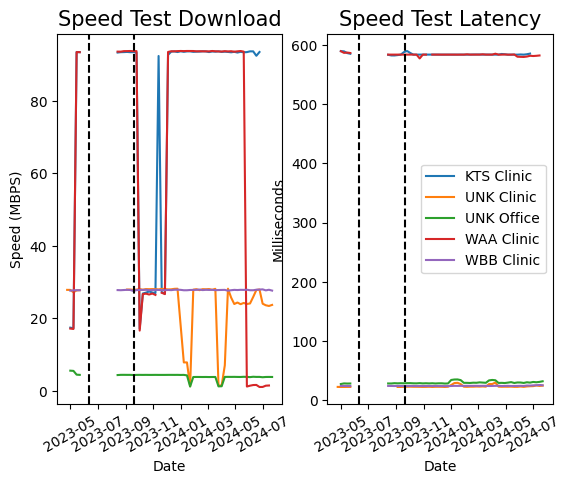

In [48]:
# Group Like Location IDs
FiberCut1 = ['KTS Clinic','UNK Clinic','UNK Office','WAA Clinic','WBB Clinic']
    
#create time series plot
df_fiber1 = ookla.groupby(['WDate', 'Location ID'])['Download'].median().unstack()
df_fiber1_lat = ookla.groupby(['WDate', 'Location ID'])['Latency'].median().unstack()

plt.subplot(1, 2, 1)

for col in FiberCut1:
    plt.plot(df_fiber1.index, df_fiber1[col], label=col)

# Adding a plot title and customizing its font size
plt.title('Speed Test Download', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)

# List of x-coordinates to draw vertical lines on
xcoords = ['2023-06-11', '2023-09-20']
xcoords = pd.to_datetime(xcoords)  # Convert xcoords to datetime objects

# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
plt.subplot(1, 2, 2)

for col in FiberCut1:
    plt.plot(df_fiber1_lat.index, df_fiber1_lat[col], label=col)
    
# Adding a plot title and customizing its font size
plt.title('Speed Test Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)

# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
plt.savefig('place_latency.jpg')


plt.show()



# Testing Whether there's a Starlink Switch

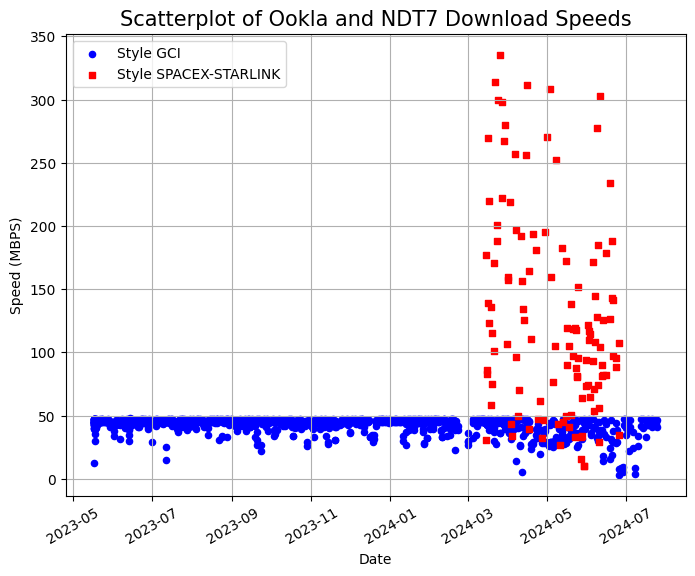

In [49]:
# Group Like Location IDs
kiana = measurements_df[measurements_df['Location ID'].isin(['Kiana Clinic','Kiana Clinic-Starlink'])]

# Adjust category labels based on your actual data
categories = kiana['AS_Name'].unique()

# Create scatterplot
plt.figure(figsize=(8, 6))

# Plot each category separately to differentiate them by color or marker
for category, marker, color in zip(categories, ['o', 's'], ['blue', 'red']):
    subset = kiana[kiana['AS_Name'] == category]
    plt.scatter(subset['Processed At'], subset['Download'], label=f'Style {category}', marker=marker, s= 20, color=color)

# 
# Add labels and legend
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.title('Scatterplot of Ookla and NDT7 Download Speeds', fontsize=15)
plt.xticks(rotation=30, fontsize=10)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


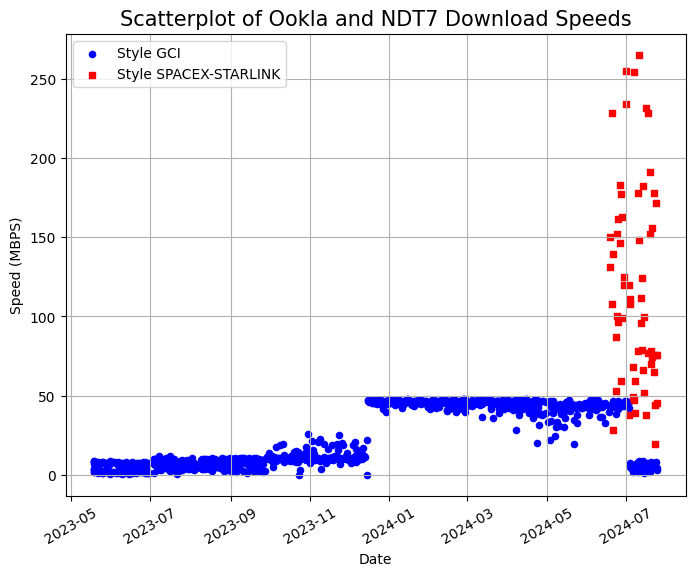

In [50]:
# Group Like Location IDs
deering = measurements_df[measurements_df['Location ID'].isin(['Deering Clinic', 'Deering Clinic- Starlink'])]

# Adjust category labels based on your actual data
categories = deering['AS_Name'].unique()

# Create scatterplot
plt.figure(figsize=(8, 6))

# Plot each category separately to differentiate them by color or marker
for category, marker, color in zip(categories, ['o', 's'], ['blue', 'red']):
    subset = deering[deering['AS_Name'] == category]
    plt.scatter(subset['Processed At'], subset['Download'], label=f'Style {category}', marker=marker, s= 20, color=color)

# 
# Add labels and legend
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.title('Scatterplot of Ookla and NDT7 Download Speeds', fontsize=15)
plt.xticks(rotation=30, fontsize=10)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


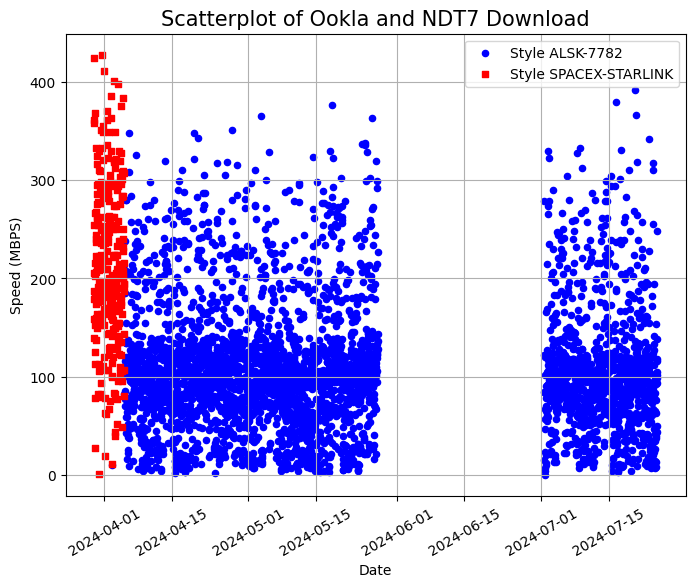

In [51]:
# Group Like Location IDs
stpaul = measurements_df[(measurements_df['Location ID'] == 'St. Paul community Health Center')]

# Adjust category labels based on your actual data
categories = stpaul['AS_Name'].unique()

# Create scatterplot
plt.figure(figsize=(8, 6))

# Plot each category separately to differentiate them by color or marker
for category, marker, color in zip(categories, ['o', 's'], ['blue', 'red']):
    subset = stpaul[stpaul['AS_Name'] == category]
    plt.scatter(subset['Processed At'], subset['Download'], label=f'Style {category}', marker=marker, s= 20, color=color)

# 
# Add labels and legend
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.title('Scatterplot of Ookla and NDT7 Download', fontsize=15)
plt.xticks(rotation=30, fontsize=10)
plt.legend()
plt.grid(True)



# Show the plot
plt.show()

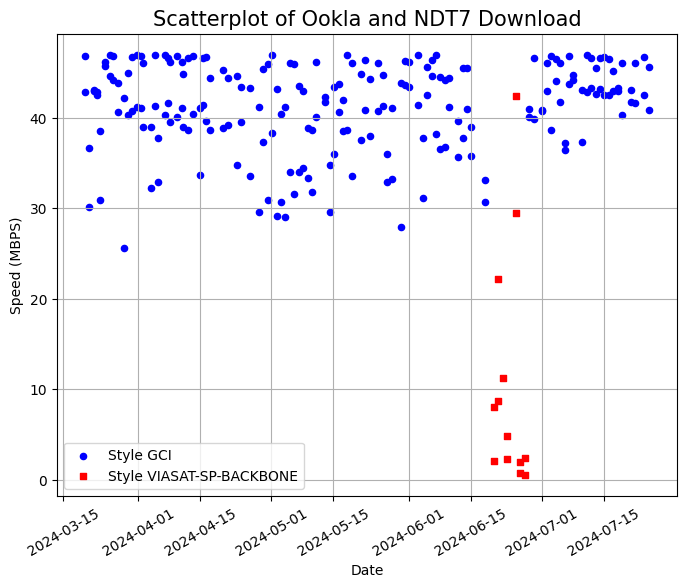

In [52]:
# Group Like Location IDs
noatak = measurements_df[(measurements_df['Location ID'] == 'Noatak Clinic')]

# Adjust category labels based on your actual data
categories = noatak['AS_Name'].unique()

# Create scatterplot
plt.figure(figsize=(8, 6))

# Plot each category separately to differentiate them by color or marker
for category, marker, color in zip(categories, ['o', 's'], ['blue', 'red']):
    subset = noatak[noatak['AS_Name'] == category]
    plt.scatter(subset['Processed At'], subset['Download'], label=f'Style {category}', marker=marker, s= 20, color=color)

# 
# Add labels and legend
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.title('Scatterplot of Ookla and NDT7 Download', fontsize=15)
plt.xticks(rotation=30, fontsize=10)
plt.legend()
plt.grid(True)


# Show the plot
plt.show()

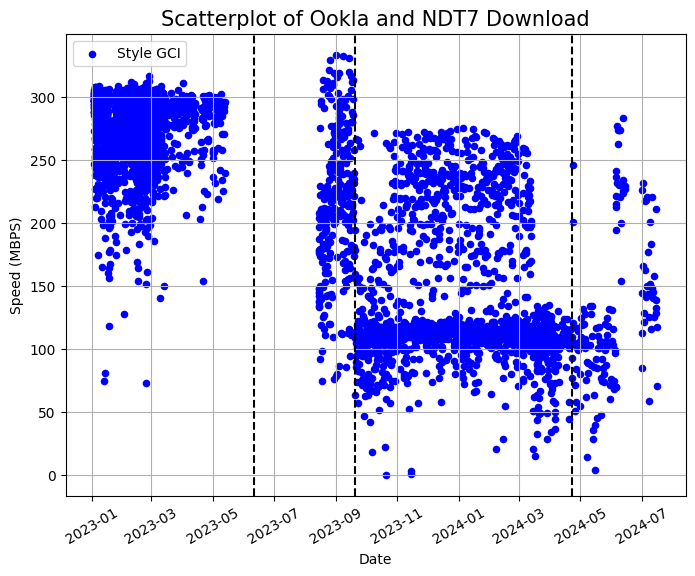

In [53]:
# Group Like Location IDs
noatak = measurements_df[(measurements_df['Location ID'] == 'NSRH')]

# Adjust category labels based on your actual data
categories = noatak['AS_Name'].unique()

# Create scatterplot
plt.figure(figsize=(8, 6))

# Plot each category separately to differentiate them by color or marker
for category, marker, color in zip(categories, ['o', 's'], ['blue', 'red']):
    subset = noatak[noatak['AS_Name'] == category]
    plt.scatter(subset['Processed At'], subset['Download'], label=f'Style {category}', marker=marker, s= 20, color=color)

# 
# Add labels and legend
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)
plt.title('Scatterplot of Ookla and NDT7 Download', fontsize=15)
plt.xticks(rotation=30, fontsize=10)
plt.legend()
plt.grid(True)

# List of x-coordinates to draw vertical lines on
xcoords = ['2023-06-11', '2023-09-20', '2024-04-23']
xcoords = pd.to_datetime(xcoords)  # Convert xcoords to datetime objects

# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Show the plot
plt.show()

# Latency and Length of Data Collection

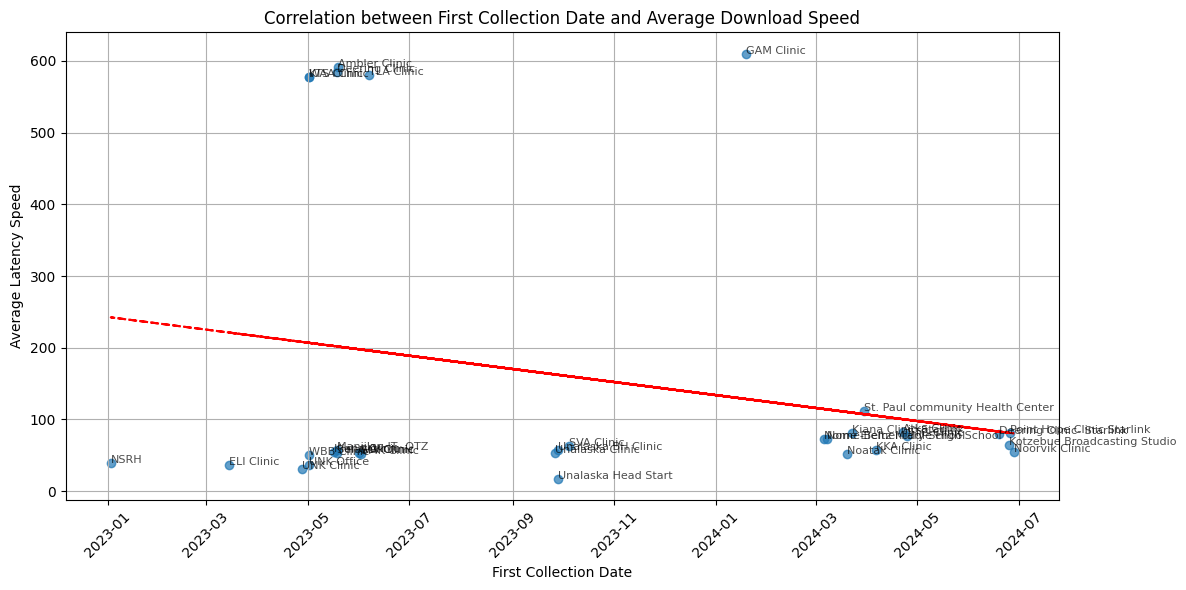

In [54]:
# Get the first date of collection per Location ID
first_dates = measurements_df.groupby('Location ID')['Processed At'].min().reset_index()
first_dates.rename(columns={'Processed At': 'First Date'}, inplace=True)

# Calculate the average download speed per location
average_speeds = measurements_df.groupby('Location ID')['Latency'].median().reset_index()
average_speeds.rename(columns={'Latency': 'Average Latency'}, inplace=True)

# Merge first dates and average speeds into a single dataframe
location_data = first_dates.merge(average_speeds, on='Location ID')

# Convert 'First Date' to numeric values for regression (ordinal format for trend line calculation)
location_data['First Date Ordinal'] = location_data['First Date'].apply(lambda x: x.toordinal())

# Fit a linear regression line
slope, intercept = np.polyfit(location_data['First Date Ordinal'], location_data['Average Latency'], 1)
trend_line = slope * location_data['First Date Ordinal'] + intercept

# Scatter plot with a trend line
plt.figure(figsize=(12, 6))
plt.scatter(location_data['First Date'], location_data['Average Latency'], alpha=0.7, label='Data Points')

# Plotting the trend line
plt.plot(location_data['First Date'], trend_line, color='red', linestyle='--', label='Trend Line')

# Label each point with the Location ID
for i in range(len(location_data)):
    plt.annotate(
        location_data['Location ID'][i], 
        (location_data['First Date'][i], location_data['Average Latency'][i]),
        fontsize=8, 
        alpha=0.7
    )

plt.xlabel('First Collection Date')
plt.ylabel('Average Latency Speed')
plt.title('Correlation between First Collection Date and Average Download Speed')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Explanation for the Cogent Download Spike

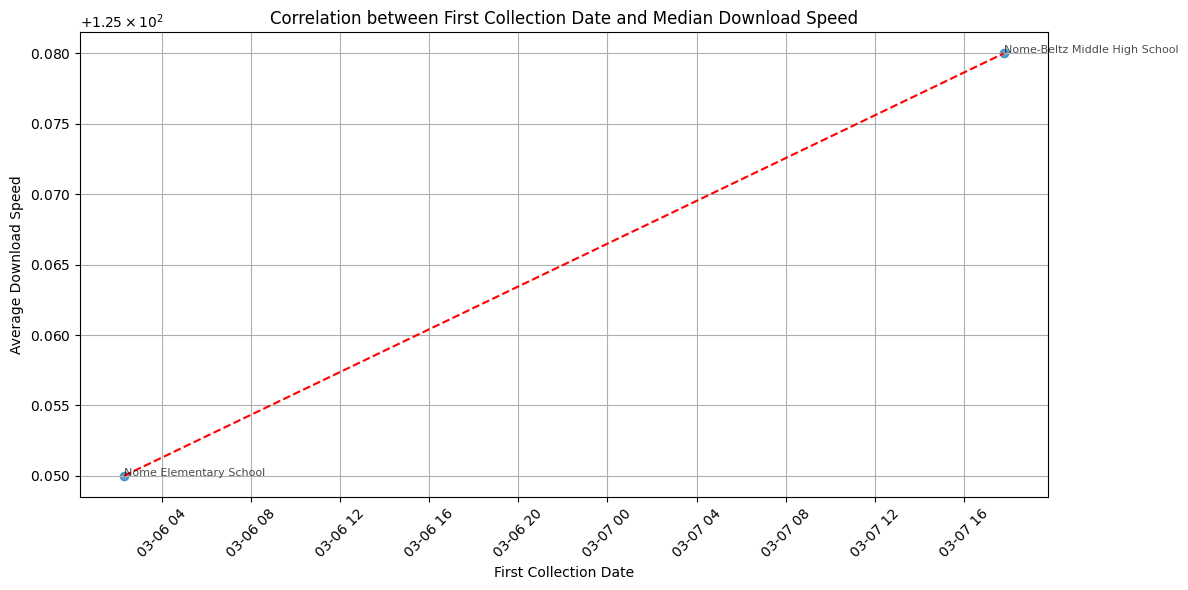

In [55]:
from matplotlib.ticker import ScalarFormatter

cogent = measurements_df[(measurements_df['AS_Name'] == 'COGENT-174')]

# Get the first date of collection per Location ID
first_dates = cogent.groupby('Location ID')['Processed At'].min().reset_index()
first_dates.rename(columns={'Processed At': 'First Date'}, inplace=True)

# Calculate the average download speed per location
average_speeds = cogent.groupby('Location ID')['Download'].median().reset_index()
average_speeds.rename(columns={'Download': 'Average Download Speed'}, inplace=True)

# Merge first dates and average speeds into a single dataframe
location_data = first_dates.merge(average_speeds, on='Location ID')

# Convert 'First Date' to numeric values for regression (ordinal format for trend line calculation)
location_data['First Date Ordinal'] = location_data['First Date'].apply(lambda x: x.toordinal())

# Fit a linear regression line
slope, intercept = np.polyfit(location_data['First Date Ordinal'], location_data['Average Download Speed'], 1)
trend_line = slope * location_data['First Date Ordinal'] + intercept

# Scatter plot with a trend line
plt.figure(figsize=(12, 6))
plt.scatter(location_data['First Date'], location_data['Average Download Speed'], alpha=0.7, label='Data Points')

# Plotting the trend line
plt.plot(location_data['First Date'], trend_line, color='red', linestyle='--', label='Trend Line')

# Label each point with the Location ID
for i in range(len(location_data)):
    plt.annotate(
        location_data['Location ID'][i], 
        (location_data['First Date'][i], location_data['Average Download Speed'][i]),
        fontsize=8, 
        alpha=0.7
    )

# Format axis to avoid scientific notation
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='y')
    
plt.xlabel('First Collection Date')
plt.ylabel('Average Download Speed')
plt.title('Correlation between First Collection Date and Median Download Speed')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# The Second Fiber Cut

In [ ]:

# Affected by the second fiber cut
#
#- Ambler
#- Kiana (Latency)
#- Maniliqz (Latency)


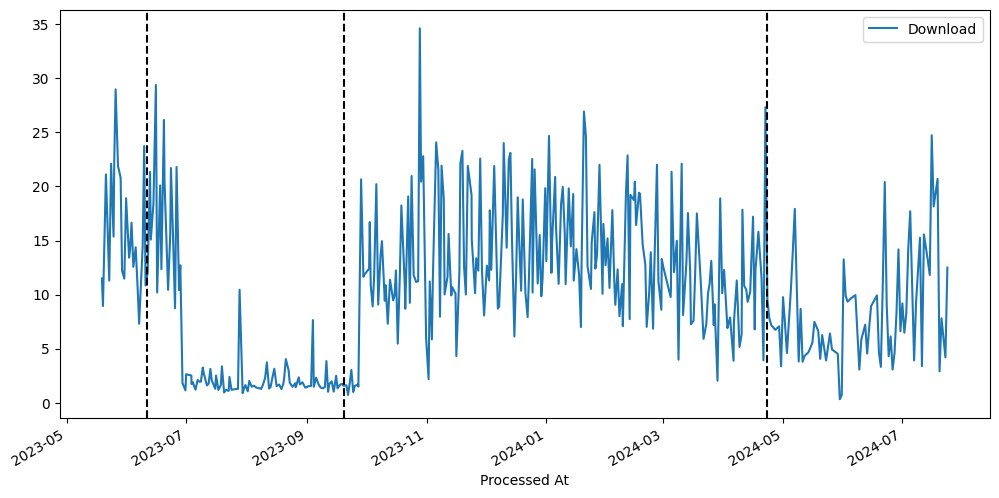

In [56]:
nsra = ookla[(ookla['Location ID'] == 'Ambler Clinic')]

ax = nsra.plot(x='Processed At', y='Download', figsize=(12,6))

xcoords = ['2023-06-11', '2023-09-20', '2024-04-23']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

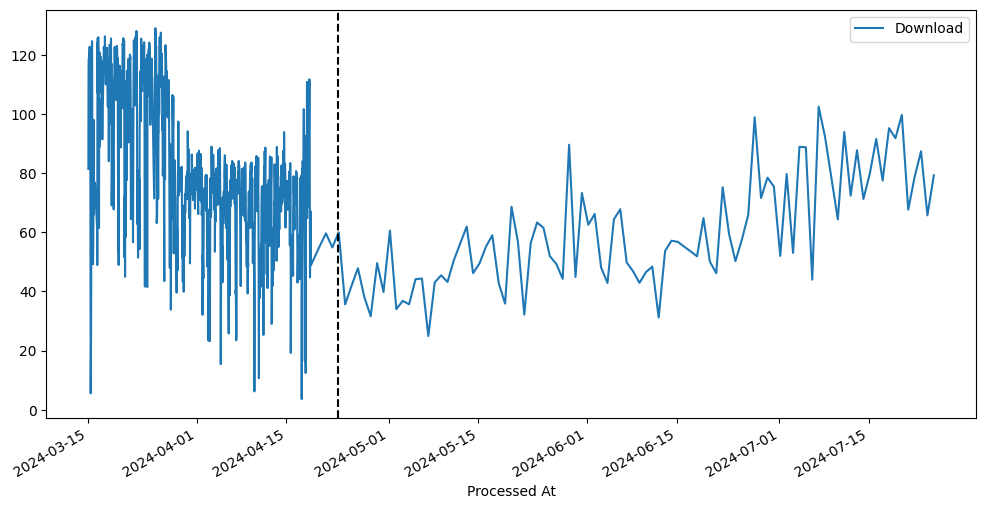

In [57]:
nsra = NDT7[(NDT7['Location ID'] == 'Maniilaq IT -OTZ')]

ax = nsra.plot(x='Processed At', y='Download', figsize=(12,6))

xcoords = ['2024-04-23']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

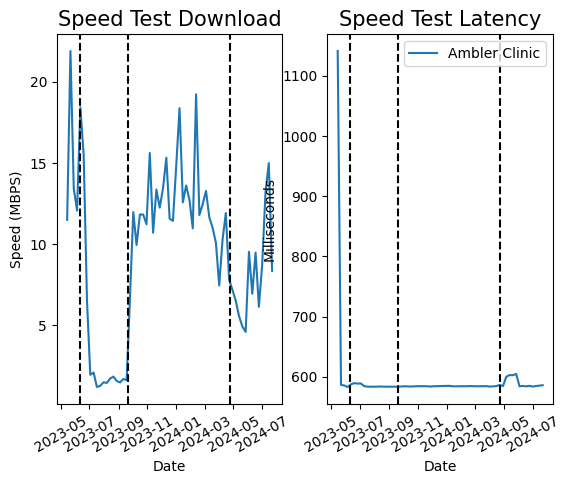

In [58]:
# Group Like Location IDs
FiberCut2 = ['Ambler Clinic']
    
#create time series plot
df_fiber2 = ookla.groupby(['WDate', 'Location ID'])['Download'].median().unstack()
df_fiber2_lat = ookla.groupby(['WDate', 'Location ID'])['Latency'].median().unstack()

plt.subplot(1, 2, 1)

for col in FiberCut2:
    plt.plot(df_fiber2.index, df_fiber2[col], label=col)

# Adding a plot title and customizing its font size
plt.title('Speed Test Download', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Speed (MBPS)', fontsize=10)

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)

# List of x-coordinates to draw vertical lines on
xcoords = ['2023-06-11', '2023-09-20', '2024-04-23']
xcoords = pd.to_datetime(xcoords)  # Convert xcoords to datetime objects

# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
plt.subplot(1, 2, 2)

for col in FiberCut2:
    plt.plot(df_fiber2_lat.index, df_fiber2_lat[col], label=col)
    
# Adding a plot title and customizing its font size
plt.title('Speed Test Latency', fontsize=15)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=10)
plt.ylabel('Milliseconds', fontsize=10)
plt.legend()

# Rotating axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=10)

# Add vertical lines to the first subplot
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
plt.savefig('place_latency.jpg')


plt.show()



# Time Series Analysis

Location ID,NSRH
Processed At,
2023-01-02 21:23:00,296.240
2023-01-02 21:54:00,296.310
2023-01-02 22:23:00,287.900
2023-01-02 22:55:00,287.650
2023-01-02 23:23:00,296.620
...,...
2024-07-13 07:36:00,141.220
2024-07-14 22:23:00,133.485
2024-07-15 00:23:00,132.350


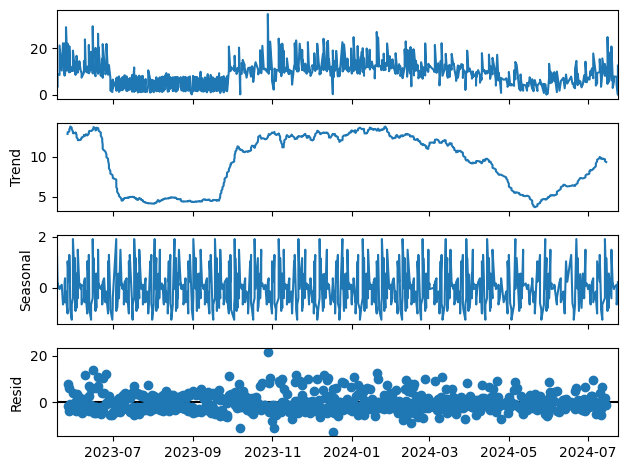

In [124]:
from statsmodels.tsa.seasonal import seasonal_decompose

time_loc = measurements_df.groupby(['Processed At', 'Location ID'])['Download'].median().unstack()
time_loc = time_loc[['Ambler Clinic']].dropna()

analysis = time_loc

decompose_result_mult = seasonal_decompose(analysis, model="additive", period = 30)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

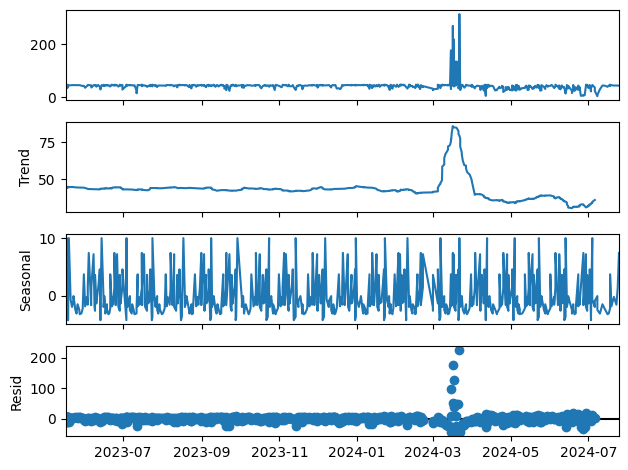

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

time_loc = measurements_df.groupby(['Processed At', 'Location ID'])['Download'].median().unstack()
time_loc = time_loc[['Kiana Clinic']].dropna()

analysis = time_loc

decompose_result_mult = seasonal_decompose(analysis, model="additive", period = 30)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

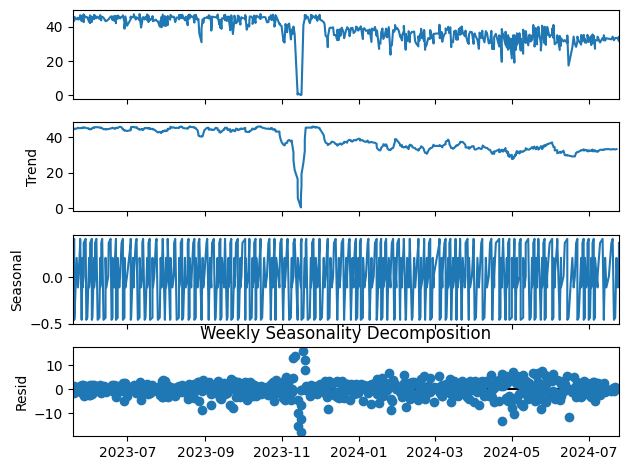

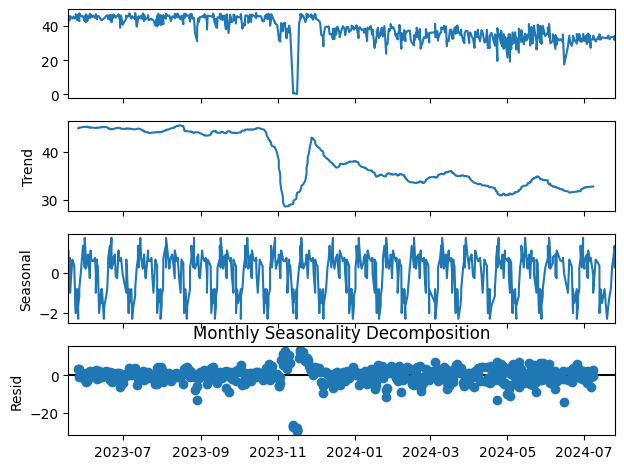

In [121]:
from statsmodels.tsa.seasonal import seasonal_decompose

time_loc = measurements_df.groupby(['Processed At', 'Location ID'])['Download'].median().unstack()
time_loc = time_loc[['Selawik Clinic']].dropna()

analysis = time_loc

# Weekly decomposition (period = 7 for weekly seasonality)
weekly_decompose = seasonal_decompose(time_loc, model="additive", period=7)
weekly_decompose.plot()
plt.title('Weekly Seasonality Decomposition')
plt.show()

# Monthly decomposition (period = 30 for approximate monthly seasonality)
monthly_decompose = seasonal_decompose(time_loc, model="additive", period=30)
monthly_decompose.plot()
plt.title('Monthly Seasonality Decomposition')
plt.show()

In [122]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test for autocorrelation in the residuals
ljung_box_test = acorr_ljungbox(residual.dropna(), lags=[10], return_df=True)
print(ljung_box_test)

       lb_stat      lb_pvalue
10  537.304939  4.663988e-109
